In [1]:
import os
import zarr
import random
import json
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
import sys
import torch
import torchvision.transforms.functional as F
import random

warnings.filterwarnings("ignore")
sys.path.append("./src/")

from src.config import CFG
from src.dataloader import (
    read_zarr,
    read_info_json,
    scale_coordinates,
    create_dataset,
    create_segmentation_map,
    EziiDataset,
    drop_padding,
)
from src.network import UNet_2D, aug
from src.utils import save_images
from src.metric import score, create_cls_pos, create_cls_pos_sikii, create_df
from metric import visualize_epoch_results

In [2]:
train_dataset = EziiDataset(
    exp_names=CFG.train_exp_names,
    base_dir="../../inputs/train/",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.train_zarr_types,
    train=True,
    random=True,
)

train_shuffle_dataset = EziiDataset(
    exp_names=CFG.train_exp_names,
    base_dir="../../inputs/train/",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.train_zarr_types,
    train=True,
)

valid_dataset = EziiDataset(
    exp_names=CFG.valid_exp_names,
    base_dir="../../inputs/train/",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.valid_zarr_types,
    train=True,
)

from tqdm import tqdm

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, drop_last=True)
train_nshuffle_loader = DataLoader(train_shuffle_dataset, batch_size=1, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

for data in tqdm(train_dataset):
    normalized_tomogram = data["normalized_tomogram"]
    segmentation_map = data["segmentation_map"]
    break

# normalized_tomogram =
normalized_tomogram.shape[0]

[('TS_4', 'denoised'), ('TS_5_4', 'denoised'), ('TS_21', 'denoised'), ('TS_3', 'denoised'), ('TS_1', 'denoised'), ('TS_73_6', 'denoised'), ('TS_7', 'denoised'), ('TS_19', 'denoised'), ('TS_5', 'denoised'), ('TS_23', 'denoised'), ('TS_12', 'denoised'), ('TS_26', 'denoised'), ('TS_8', 'denoised'), ('TS_99_9', 'denoised'), ('TS_20', 'denoised'), ('TS_6_4', 'denoised'), ('TS_69_2', 'denoised'), ('TS_17', 'denoised'), ('TS_0', 'denoised'), ('TS_16', 'denoised'), ('TS_2', 'denoised'), ('TS_10', 'denoised'), ('TS_25', 'denoised'), ('TS_24', 'denoised'), ('TS_22', 'denoised'), ('TS_6', 'denoised'), ('TS_9', 'denoised'), ('TS_15', 'denoised'), ('TS_18', 'denoised'), ('TS_13', 'denoised'), ('TS_14', 'denoised'), ('TS_11', 'denoised')]
[('TS_4', 'denoised'), ('TS_5_4', 'denoised'), ('TS_21', 'denoised'), ('TS_3', 'denoised'), ('TS_1', 'denoised'), ('TS_73_6', 'denoised'), ('TS_7', 'denoised'), ('TS_19', 'denoised'), ('TS_5', 'denoised'), ('TS_23', 'denoised'), ('TS_12', 'denoised'), ('TS_26', 'de

  0%|          | 0/32 [00:01<?, ?it/s]


50

In [3]:
# torchのpadding用の関数
# torch.Size([4, 1, 158, 158]) -> torch.Size([4, 1, 160, 160])


class PadToSize(nn.Module):
    def __init__(self, resolution):
        super().__init__()
        if resolution == "0":
            self.size = 640
        elif resolution == "1":
            self.size = 320
        elif resolution == "2":
            self.size = 160

    def forward(self, x):
        return F.pad(x, (0, 0, self.size - x.shape[-1], self.size - x.shape[-2]))


# test
pad = PadToSize(CFG.resolution)
test_input = torch.randn((4, 1, 158, 158))
print(test_input.shape)
print(pad(test_input).shape)

torch.Size([4, 1, 158, 158])
torch.Size([4, 1, 160, 160])


In [4]:
model = UNet_2D().to("cuda")
# model.load_state_dict(torch.load("./pretrained_model.pth"))
# model.eval()

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# サンプルデータ
num_classes = len(CFG.particles_name)  # クラス数
colors = plt.cm.tab10(
    np.arange(len(CFG.particles_name))
)  # "tab10" カラーマップから色を取得

# ListedColormap を作成
class_colormap = ListedColormap(colors)


# カラーバー付きプロット
def plot_with_colormap(data, title, original_tomogram):
    masked_data = np.ma.masked_where(data <= 0, data)  # クラス0をマスク
    plt.imshow(original_tomogram, cmap="gray")
    im = plt.imshow(masked_data, cmap=class_colormap)
    plt.title(title)
    plt.axis("off")
    return im

In [6]:
class SegmentationLoss(nn.Module):
    def __init__(self, criterion):
        super().__init__()
        self.softmax = nn.Softmax(dim=1)
        self.criterion = criterion

    def forward(self, output, target):
        # output: (batch, cls, 160, 160)
        # target: (batch, 160, 160)

        # output, (batch, 160, 160, cls) -> (batch, 160, 160, cls)
        output = output.permute(0, 2, 3, 1)
        output = output.reshape(-1, output.shape[-1])  # (batch*160*160, cls)

        # target, (batch, 160, 160) -> (batch*160*160)
        target = target.reshape(-1)

        loss = self.criterion(output, target)
        return loss


class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, output, target):
        """
        output: (batch, cls, height, width)
        target: (batch, height, width)
        """
        # Apply softmax to get probabilities
        output = nn.functional.softmax(output, dim=1)

        # One-hot encode the target to match the number of classes in output
        num_classes = output.shape[1]
        target_one_hot = (
            # F.one_hot(target, num_classes=num_classes).permute(0, 3, 1, 2).float()
            nn.functional.one_hot(target, num_classes=num_classes)
            .permute(0, 3, 1, 2)
            .float()
        )

        # Flatten for Dice calculation
        output_flat = output.reshape(output.shape[0], output.shape[1], -1)
        target_flat = target_one_hot.reshape(
            target_one_hot.shape[0], target_one_hot.shape[1], -1
        )

        # Compute intersection and union
        intersection = (output_flat * target_flat).sum(dim=2)
        union = output_flat.sum(dim=2) + target_flat.sum(dim=2)

        # Compute Dice score
        dice_score = (2.0 * intersection + self.smooth) / (union + self.smooth)

        # Average over classes and batch
        dice_loss = 1.0 - dice_score.mean()

        return dice_loss


# test
dice_loss = DiceLoss()
output = torch.randn((4, 3, 160, 160))
target = torch.randint(0, 3, (4, 160, 160))
print(dice_loss(output, target))

tensor(0.6661)


In [7]:
from transformers import get_cosine_schedule_with_warmup

batch_size = CFG.batch_size

optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
criterion = nn.CrossEntropyLoss(
    weight=torch.tensor([2.0, 32, 32, 32, 32, 32, 32]).to("cuda")
)
# criterion = DiceLoss()
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=CFG.epochs // 10,
    num_training_steps=CFG.epochs
    * len(train_loader)
    * (normalized_tomogram.shape[0] // batch_size),
    # * batch_size,
)
seg_loss = SegmentationLoss(criterion)
padf = PadToSize(CFG.resolution)

Train-Epoch: 0, Loss: 0.5987793521521843: : 219it [00:45,  4.86it/s]                       
Train-nshuffle-Epoch: 0, Loss: 0.467060335830467:  99%|█████████▉| 1580/1600 [00:47<00:00, 33.11it/s]  


EPOCH: 0, TRAIN_SCORE: 0.09261924317378892, TRAIN_SCORE_LIST: [0.0, 0.07600081284291811, 0.128939617083947, 0.0, 0.0, 0.09567099567099567, 0.07310081223124701, 0.1379519166717132, 0.0, 0.13704698961435108, 0.14227773128178717, 0.11841027041791861, 0.04415584415584416, 0.07804482851741831, 0.14043139054612208, 0.0980140935297886, 0.06598222110930262, 0.14030261348005502, 0.0, 0.13650631432951307, 0.0, 0.11530309453158118, 0.1270695075096053, 0.12938137131685518, 0.13376164007796146, 0.026835043409629045, 0.13423376623376623, 0.139948006932409, 0.13518886679920478, 0.1411417592973789, 0.1410833069369655, 0.12703296703296704]
EPOCH: 0, TRAIN_EASY_SCORE: 0.020727606145841213, TRAIN_EASY_SCORE_LIST: [0.0015331890331890335, 0.05206577595066803, 0.01153323978202366, 0.0016900288299035687, 0.0017175186906445744, 0.03081755124308316, 0.005535161444737522, 0.019432639244500737, 0.001614741641337386, 0.009963992491527523, 0.017966703930552712, 0.01582338132826503, 0.006742967457253173, 0.06019433

Valid-Epoch: 0, Loss: 0.4932095425547627:  92%|█████████▏| 92/100 [00:00<00:00, 94.57it/s]  


EPOCH: 0, VALID_SCORE: 0.05524997218075069, VALID_SCORE_LIST: [0.0733390854184642, 0.03716085894303716]
EPOCH: 0, VALID_EASY_SCORE: 0.045391213493335456, VALID_EASY_SCORE_LIST: [0.04275653923541247, 0.04802588775125844]


Train-Epoch: 1, Loss: 0.432383816842347: : 219it [00:43,  5.04it/s]                         
Train-nshuffle-Epoch: 1, Loss: 0.47447280163369787:  99%|█████████▉| 1580/1600 [00:46<00:00, 33.69it/s]


EPOCH: 1, TRAIN_SCORE: 0.06647326482117935, TRAIN_SCORE_LIST: [0.04415584415584416, 0.02835696413678065, 0.04823874755381604, 0.01527403414195867, 0.0, 0.03848766130858049, 0.1365827530798072, 0.06523407521105141, 0.04415584415584416, 0.055869364280579224, 0.1104656886876046, 0.040611562350692784, 0.13574938574938578, 0.09215132693393562, 0.06368330464716007, 0.05768226900991822, 0.024271436969849673, 0.05667366341523645, 0.0, 0.07136683541177923, 0.0, 0.13579959671164885, 0.035568987562478206, 0.05510842834786497, 0.048844960349385125, 0.13908719018208068, 0.1338345864661654, 0.08891794704151683, 0.046703296703296704, 0.09134993446920052, 0.0919459141681364, 0.1309728710761413]
EPOCH: 1, TRAIN_EASY_SCORE: 0.017389630563713544, TRAIN_EASY_SCORE_LIST: [0.006419650660093317, 0.05264963416096917, 0.005874872054690415, 0.007039305104289976, 0.0017175186906445744, 0.02778339747917799, 0.016048669105826828, 0.016176919711332616, 0.010429882942867074, 0.007163911114949019, 0.01955876481268033

Valid-Epoch: 1, Loss: 0.4232876322272679:  92%|█████████▏| 92/100 [00:01<00:00, 89.09it/s]  


EPOCH: 1, VALID_SCORE: 0.012029622333055424, VALID_SCORE_LIST: [0.01496347152539389, 0.009095773140716959]
EPOCH: 1, VALID_EASY_SCORE: 0.04412195445289055, VALID_EASY_SCORE_LIST: [0.03875880281690141, 0.04948510608887968]


Train-Epoch: 2, Loss: 0.40911550619150405: : 219it [00:41,  5.30it/s]                       
Train-nshuffle-Epoch: 2, Loss: 0.49347842302662615:  99%|█████████▉| 1580/1600 [00:44<00:00, 35.46it/s]


EPOCH: 2, TRAIN_SCORE: 0.08376278371362222, TRAIN_SCORE_LIST: [0.0, 0.04809052333804809, 0.1401098901098901, 0.0, 0.0, 0.08269329237071173, 0.01420217209690894, 0.14165858113121393, 0.0, 0.14118221787982416, 0.1402880498248346, 0.13841598815692083, 0.0, 0.034859876965140126, 0.14142079119037645, 0.09028146574614974, 0.09739419700609868, 0.14137214137214138, 0.0, 0.14149164445022433, 0.0, 0.03469387755102041, 0.13905269164922962, 0.1413677547474246, 0.14169271312128454, 0.0, 0.0957905203844879, 0.14100024758603616, 0.14043478260869566, 0.13835497835497831, 0.13842991540833266, 0.0761307657859382]
EPOCH: 2, TRAIN_EASY_SCORE: 0.017566702634507318, TRAIN_EASY_SCORE_LIST: [0.0015331890331890335, 0.056803874092009675, 0.010749513625163173, 0.0016900288299035687, 0.0017175186906445744, 0.030308373496336354, 0.006573064460904674, 0.01768400615607111, 0.001614741641337386, 0.01271031567487099, 0.016359187562253692, 0.016463509787942362, 0.001640926640926641, 0.06365207373271889, 0.0143318267579

Valid-Epoch: 2, Loss: 0.4333546681673792:  92%|█████████▏| 92/100 [00:01<00:00, 90.84it/s]  


EPOCH: 2, VALID_SCORE: 0.07743138875214346, VALID_SCORE_LIST: [0.09237809237809237, 0.06248468512619455]
EPOCH: 2, VALID_EASY_SCORE: 0.04673291798218317, VALID_EASY_SCORE_LIST: [0.0391818121845829, 0.05428402377978343]


Train-Epoch: 3, Loss: 0.41491039168753036: : 219it [00:44,  4.95it/s]                       
Train-nshuffle-Epoch: 3, Loss: 0.49475363308616876:  99%|█████████▉| 1580/1600 [00:53<00:00, 29.52it/s]


EPOCH: 3, TRAIN_SCORE: 0.06381154321284077, TRAIN_SCORE_LIST: [0.13940092165898615, 0.011809656130600903, 0.04463524257963658, 0.1410138248847926, 0.0, 0.013335657630959643, 0.16033576128634705, 0.04168134326864486, 0.14119601328903653, 0.033177550868309244, 0.06146963289820433, 0.030964446719143883, 0.10670995670995671, 0.10125910929109445, 0.030950111404148637, 0.04974246532688092, 0.01802594334686702, 0.037117879050634774, 0.013492063492063491, 0.03802578345342319, 0.0, 0.15331753085517594, 0.027107077500134254, 0.028793328290450226, 0.03544491218860522, 0.11978319783197833, 0.12852839462646018, 0.04386203150461705, 0.0325899493528037, 0.05371081650353116, 0.10986911481917995, 0.09461966604823747]
EPOCH: 3, TRAIN_EASY_SCORE: 0.038914436643311165, TRAIN_EASY_SCORE_LIST: [0.012734147403958727, 0.08017631855757279, 0.028045121826916233, 0.01745997317127648, 0.0017175186906445744, 0.0572571049928753, 0.03773218885482508, 0.06396728182847414, 0.010129405785140603, 0.04455651230151677, 0.

Valid-Epoch: 3, Loss: 0.7600024224906836:  92%|█████████▏| 92/100 [00:00<00:00, 94.72it/s] 


EPOCH: 3, VALID_SCORE: 0.029212138103497497, VALID_SCORE_LIST: [0.030067934167546075, 0.02835634203944892]
EPOCH: 3, VALID_EASY_SCORE: 0.06522688170060151, VALID_EASY_SCORE_LIST: [0.05453443317915385, 0.07591933022204918]


Train-Epoch: 4, Loss: 0.426132048509981: : 219it [00:40,  5.35it/s]                         
Train-nshuffle-Epoch: 4, Loss: 0.4194999702522366:  99%|█████████▉| 1580/1600 [00:44<00:00, 35.53it/s] 


EPOCH: 4, TRAIN_SCORE: 0.07654817913961617, TRAIN_SCORE_LIST: [0.12927756653992398, 0.03145536910610604, 0.06194018521329892, 0.09511376352107422, 0.0, 0.03201970443349754, 0.1384757790805307, 0.06959892757508786, 0.11258278145695365, 0.0619953112789789, 0.09844372059355773, 0.05372434416202256, 0.14066682891214408, 0.09043329043329043, 0.06693155138161459, 0.0536790737728447, 0.022587973083022583, 0.06737034637808179, 0.0, 0.07132771210715294, 0.0, 0.1366944477051297, 0.052602301567986655, 0.0576460293152483, 0.055584542071028566, 0.14156607062165125, 0.13486164032731587, 0.07945162797943606, 0.06026550007542616, 0.09467935546663783, 0.10518437203732348, 0.13338161627135012]
EPOCH: 4, TRAIN_EASY_SCORE: 0.030453134080292214, TRAIN_EASY_SCORE_LIST: [0.010670026612464538, 0.11382832061963777, 0.016652300444131334, 0.012435920106768295, 0.0017175186906445744, 0.02748627158152827, 0.015432168054484352, 0.03194381105293393, 0.01719915722575297, 0.015349149904839196, 0.015872535847132878, 0.

Valid-Epoch: 4, Loss: 0.5806790209253845:  92%|█████████▏| 92/100 [00:00<00:00, 110.90it/s]


EPOCH: 4, VALID_SCORE: 0.01598047280389958, VALID_SCORE_LIST: [0.019340892714930415, 0.012620052892868744]
EPOCH: 4, VALID_EASY_SCORE: 0.042355170409029946, VALID_EASY_SCORE_LIST: [0.03809717278027137, 0.04661316803778853]


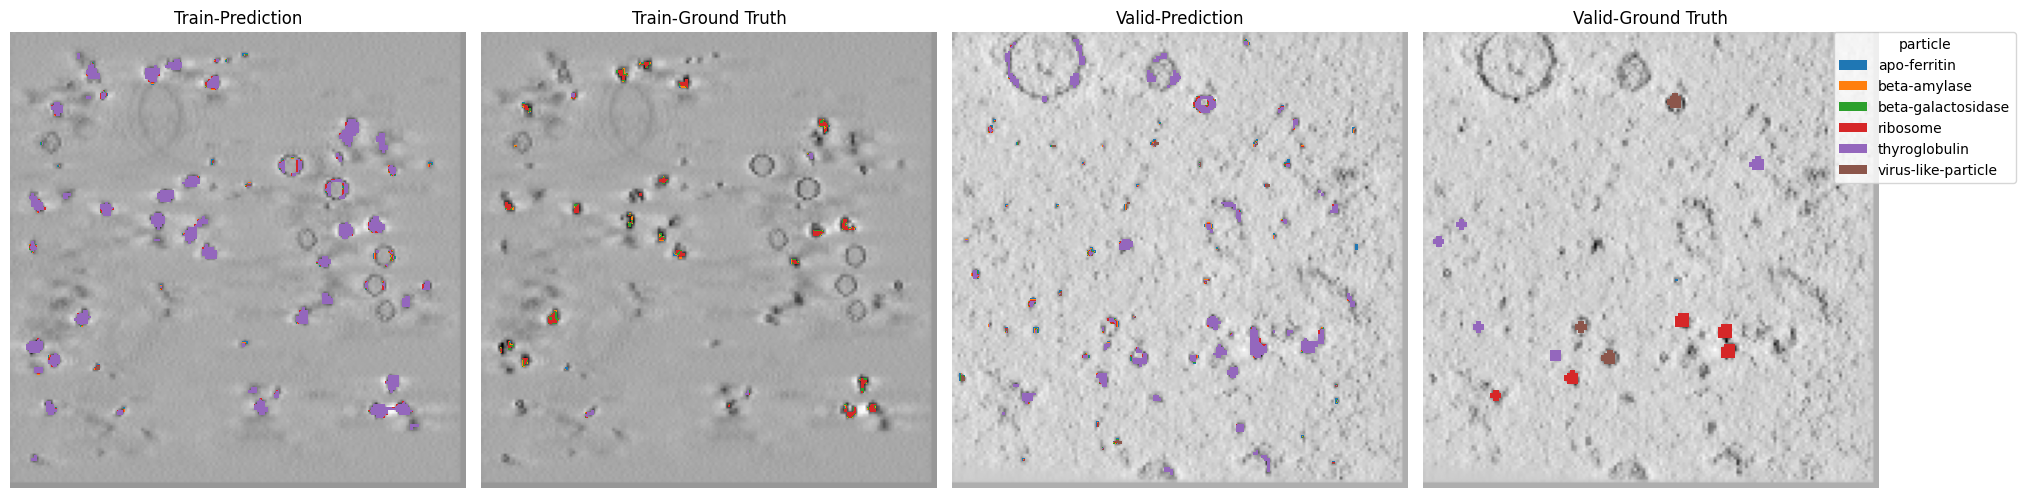

Train-Epoch: 5, Loss: 0.4147566979130109: : 219it [00:40,  5.42it/s]                        
Train-nshuffle-Epoch: 5, Loss: 0.4097983641685517:  99%|█████████▉| 1580/1600 [00:44<00:00, 35.62it/s] 


EPOCH: 5, TRAIN_SCORE: 0.09568210819289845, TRAIN_SCORE_LIST: [0.12892995035852178, 0.05859715794773961, 0.08084010303150387, 0.08374384236453201, 0.0, 0.11469857160433414, 0.139692008034573, 0.08538236450189982, 0.10031055900621119, 0.0795331033505033, 0.10946492677645449, 0.06319966583124478, 0.14081632653061224, 0.17312215890252552, 0.07905973872236081, 0.12912852516831014, 0.08897381368079671, 0.07913574283079354, 0.0, 0.086949916443004, 0.0, 0.13778425655976675, 0.06147387671973066, 0.07053941908713694, 0.07094703049759228, 0.14178302900107412, 0.18376147354155117, 0.0992063492063492, 0.07306171566099363, 0.10789127050652615, 0.16029538076567354, 0.13350518554043522]
EPOCH: 5, TRAIN_EASY_SCORE: 0.03596564741007234, TRAIN_EASY_SCORE_LIST: [0.01263100211120013, 0.1057519443046957, 0.024368265048956176, 0.009600684949028743, 0.0017175186906445744, 0.03675684061925811, 0.01617775668566767, 0.033041796364613706, 0.013895760243468504, 0.02520722571804357, 0.028567671368265133, 0.0572292

Valid-Epoch: 5, Loss: 0.5127545083042883:  92%|█████████▏| 92/100 [00:00<00:00, 118.28it/s]


EPOCH: 5, VALID_SCORE: 0.06605100762571237, VALID_SCORE_LIST: [0.060759709553600535, 0.07134230569782418]
EPOCH: 5, VALID_EASY_SCORE: 0.10576599071844534, VALID_EASY_SCORE_LIST: [0.04532308239898344, 0.16620889903790723]


Train-Epoch: 6, Loss: 0.41754921362416386: : 219it [00:41,  5.33it/s]                       
Train-nshuffle-Epoch: 6, Loss: 0.42564656227897807:  99%|█████████▉| 1580/1600 [00:45<00:00, 34.95it/s]


EPOCH: 6, TRAIN_SCORE: 0.09126672133533228, TRAIN_SCORE_LIST: [0.0, 0.07256235827664399, 0.08935611038107753, 0.0, 0.0, 0.0785613823588507, 0.140447504302926, 0.11518597488746743, 0.0, 0.10033951423348132, 0.1362923371870098, 0.08498559566175225, 0.1380510440835267, 0.08631810072732263, 0.12273716621542709, 0.09437453737971872, 0.051784737952042484, 0.11406043390959399, 0.0, 0.12216154067260705, 0.0, 0.14038577456298976, 0.10021392916567626, 0.09701562353821684, 0.10785792292890946, 0.13848996388678927, 0.14172571904960402, 0.12586027111574555, 0.10319028797289666, 0.13964831215505066, 0.13675450762829405, 0.14217443249701317]
EPOCH: 6, TRAIN_EASY_SCORE: 0.026618198358024252, TRAIN_EASY_SCORE_LIST: [0.0015331890331890335, 0.1919641814493703, 0.00899385150256318, 0.0016900288299035687, 0.0017175186906445744, 0.029287993380902693, 0.012759115383506162, 0.020275867356909807, 0.001614741641337386, 0.010248624613119388, 0.016554965890514063, 0.012858474959639788, 0.01758609258609259, 0.0601

Valid-Epoch: 6, Loss: 0.4674469227902591:  92%|█████████▏| 92/100 [00:00<00:00, 97.28it/s]  


EPOCH: 6, VALID_SCORE: 0.05299272340979422, VALID_SCORE_LIST: [0.05887445887445888, 0.04711098794512956]
EPOCH: 6, VALID_EASY_SCORE: 0.04458988737816813, VALID_EASY_SCORE_LIST: [0.040981379347513655, 0.04819839540882261]


Train-Epoch: 7, Loss: 0.3991596348005343: : 219it [00:41,  5.33it/s]                        
Train-nshuffle-Epoch: 7, Loss: 0.41624424322331444:  99%|█████████▉| 1580/1600 [00:43<00:00, 36.38it/s]


EPOCH: 7, TRAIN_SCORE: 0.10014342289134495, TRAIN_SCORE_LIST: [0.10204081632653061, 0.055081001472754056, 0.07615729218516674, 0.04692891649413388, 0.0, 0.09040400031748551, 0.14215542950704635, 0.10298899728272974, 0.051452784503631964, 0.08478034184159224, 0.21927783897182201, 0.075018698578908, 0.14209726443768997, 0.14899711748138061, 0.1062246601478655, 0.0840571963116397, 0.042071397636577364, 0.10204721587600232, 0.0, 0.09930006546150359, 0.0, 0.14000633512828634, 0.08465608465608467, 0.08627631910074658, 0.09000311429461227, 0.14163942831506762, 0.21045846333692814, 0.14270907970820984, 0.08694344163658244, 0.18071204085248796, 0.12863401035444047, 0.14147018030513175]
EPOCH: 7, TRAIN_EASY_SCORE: 0.041924901913709525, TRAIN_EASY_SCORE_LIST: [0.004758383493443255, 0.15325312387271386, 0.022300108957206292, 0.006527820520284901, 0.0017175186906445744, 0.0566984933653075, 0.015670042579185483, 0.04297792231493904, 0.005897936400722621, 0.024077442164762233, 0.029428866910311744, 0

Valid-Epoch: 7, Loss: 0.49161499591908703:  92%|█████████▏| 92/100 [00:00<00:00, 92.99it/s] 


EPOCH: 7, VALID_SCORE: 0.059896814301342846, VALID_SCORE_LIST: [0.042691627190228856, 0.07710200141245684]
EPOCH: 7, VALID_EASY_SCORE: 0.15306288611050983, VALID_EASY_SCORE_LIST: [0.170994914034775, 0.1351308581862447]


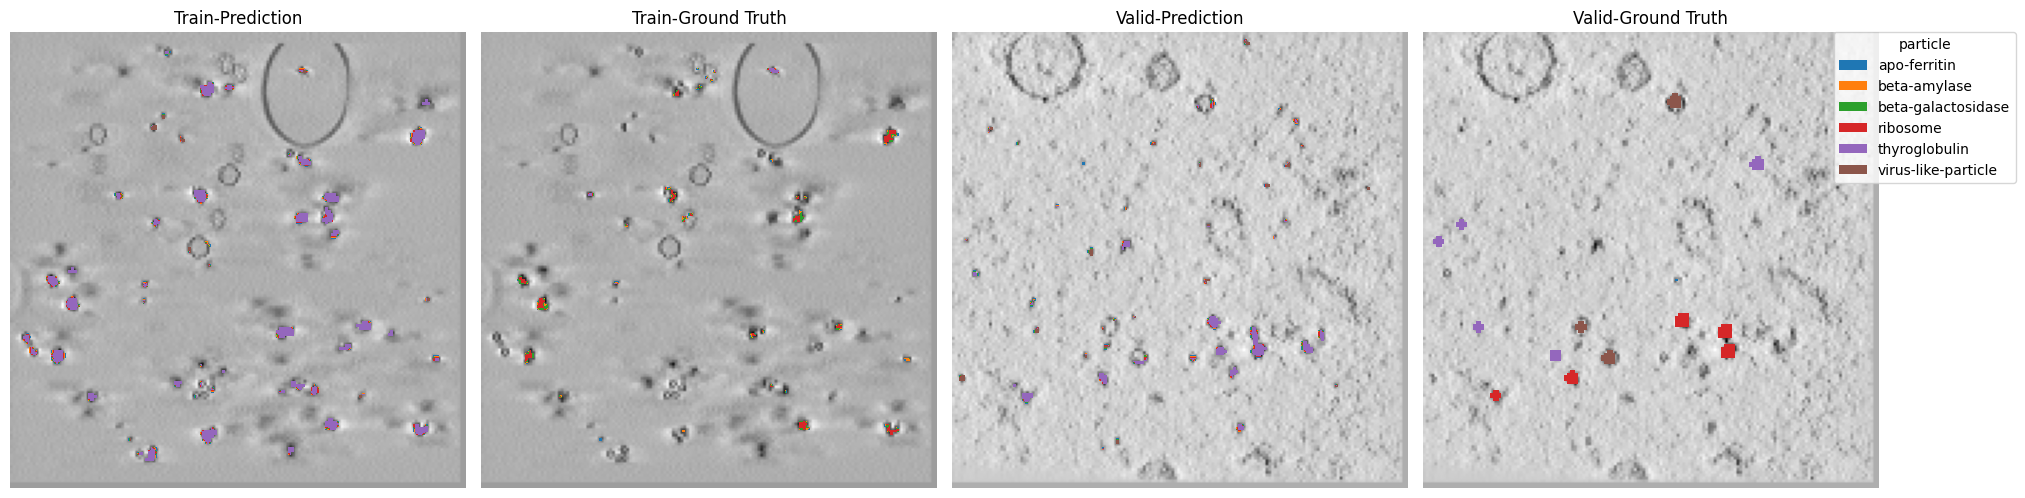

Train-Epoch: 8, Loss: 0.400528992351876: : 219it [00:41,  5.32it/s]                         
Train-nshuffle-Epoch: 8, Loss: 0.48628314298111947:  99%|█████████▉| 1580/1600 [00:46<00:00, 33.93it/s]


EPOCH: 8, TRAIN_SCORE: 0.05840287356229953, TRAIN_SCORE_LIST: [0.13346203346203345, 0.00716524854455889, 0.15082247441372756, 0.14158103297736582, 0.04560697518443997, 0.008266366381737217, 0.06652436855211669, 0.03593186621907248, 0.13391376451077944, 0.02754870539090352, 0.046081644212485326, 0.07806280034876265, 0.08521303258145363, 0.036201350188029544, 0.03137858104210729, 0.016531777401342616, 0.007582316673225764, 0.026664465266025512, 0.04976580796252928, 0.08699833184369266, 0.03794642857142857, 0.0684220735137232, 0.07433737061459292, 0.09180767452612114, 0.028327575695996747, 0.08213883072958608, 0.05805350028457599, 0.03993539861987961, 0.023992472949662853, 0.03668349060054129, 0.04153852635126596, 0.07040566837982136]
EPOCH: 8, TRAIN_EASY_SCORE: 0.029834702821583216, TRAIN_EASY_SCORE_LIST: [0.012231741581961848, 0.15695642615310204, 0.019665148356387174, 0.01873615363820839, 0.007114344087469971, 0.02714459884370719, 0.01478924347799698, 0.02640657477495806, 0.00958307662

Valid-Epoch: 8, Loss: 0.7976150450742115:  92%|█████████▏| 92/100 [00:00<00:00, 112.33it/s]


EPOCH: 8, VALID_SCORE: 0.002725141804110559, VALID_SCORE_LIST: [0.0029513248410407765, 0.0024989587671803413]
EPOCH: 8, VALID_EASY_SCORE: 0.041332862568878526, VALID_EASY_SCORE_LIST: [0.036426485743730676, 0.046239239394026375]


Train-Epoch: 9, Loss: 0.40204627114479946: : 219it [00:40,  5.36it/s]                       
Train-nshuffle-Epoch: 9, Loss: 0.42378024432301237:  99%|█████████▉| 1580/1600 [00:45<00:00, 35.03it/s]


EPOCH: 9, TRAIN_SCORE: 0.18459835368898553, TRAIN_SCORE_LIST: [0.0, 0.11598229148135435, 0.18906756762322433, 0.0, 0.0, 0.15300343827951188, 0.14070385572976246, 0.2538683467284134, 0.0, 0.23648780004207298, 0.3053349886056204, 0.2054860286759552, 0.2048375377236113, 0.163307093820689, 0.30261100451576645, 0.13056866623226837, 0.14623515192572692, 0.28927973558473347, 0.0, 0.28153319249664766, 0.0, 0.24491690519324844, 0.22599068806810593, 0.22654505987839318, 0.22523348548157407, 0.13823504236925446, 0.2551312431282424, 0.3148280413555026, 0.2441817910060644, 0.36152598060259356, 0.3007483893574055, 0.2515039921417939]
EPOCH: 9, TRAIN_EASY_SCORE: 0.03645552311897795, TRAIN_EASY_SCORE_LIST: [0.0015331890331890335, 0.13959480286434592, 0.019862529055690265, 0.0016900288299035687, 0.0017175186906445744, 0.037677638258891935, 0.015526404214308075, 0.042916207206028165, 0.001614741641337386, 0.025998002762202415, 0.037407827566647754, 0.0332435758625189, 0.03024504941260223, 0.080805985831

Valid-Epoch: 9, Loss: 0.38886672205737105:  92%|█████████▏| 92/100 [00:00<00:00, 104.03it/s]


EPOCH: 9, VALID_SCORE: 0.1229701935536136, VALID_SCORE_LIST: [0.13203888293689153, 0.11390150417033569]
EPOCH: 9, VALID_EASY_SCORE: 0.05336783960576438, VALID_EASY_SCORE_LIST: [0.050885509614728444, 0.05585016959680033]


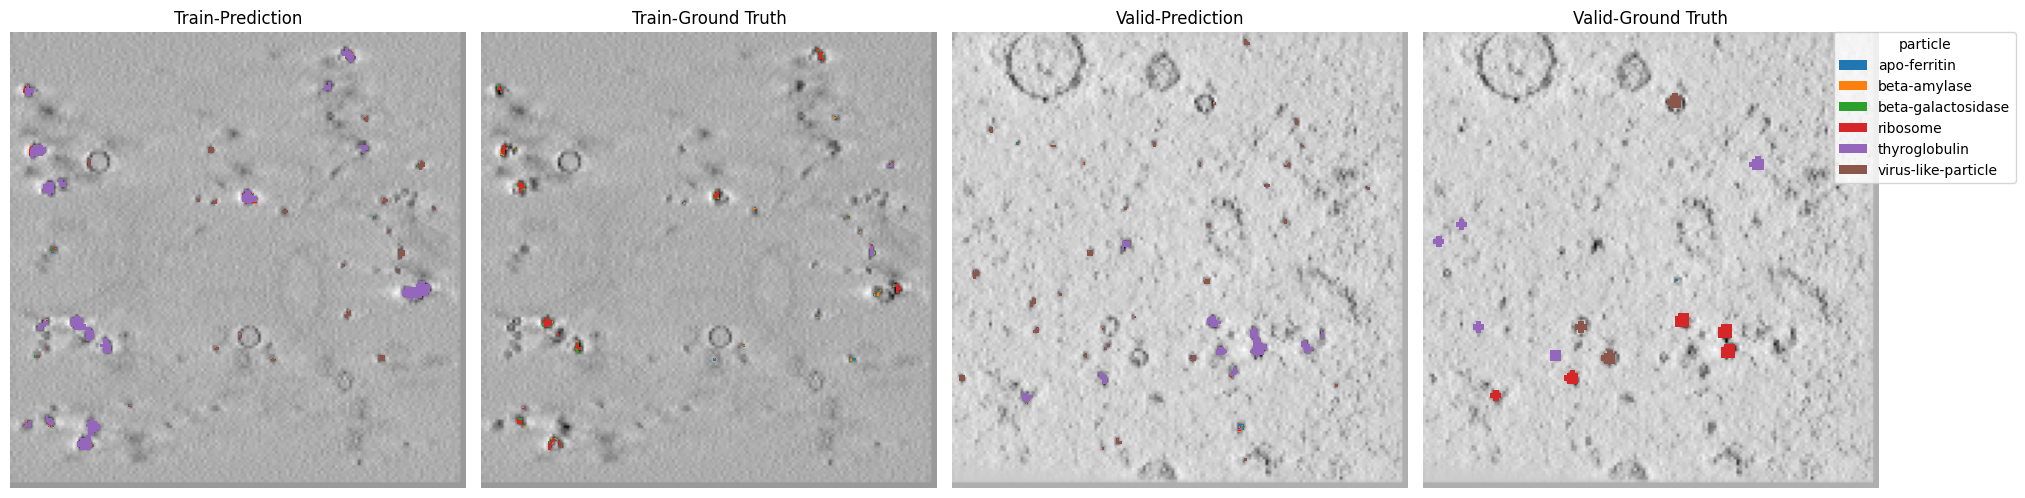

Train-Epoch: 10, Loss: 0.4280377306282248: : 219it [00:41,  5.31it/s]                        
Train-nshuffle-Epoch: 10, Loss: 0.4327028933893359:  99%|█████████▉| 1580/1600 [00:46<00:00, 33.63it/s] 


EPOCH: 10, TRAIN_SCORE: 0.08248738877454728, TRAIN_SCORE_LIST: [0.11258278145695365, 0.04078087517577964, 0.06760071354244092, 0.06666666666666667, 0.0, 0.04368648522368882, 0.14181438998957246, 0.08637873754152825, 0.08374384236453203, 0.07053941908713693, 0.11051016693535805, 0.06358400635509069, 0.14240434684174777, 0.09874568566377641, 0.08272506082725062, 0.06791307126877597, 0.030305950373404, 0.08512803810609453, 0.0, 0.08003166270882807, 0.0, 0.1395730706075534, 0.0693877551020408, 0.06722689075630253, 0.06380292742843494, 0.14244409039948072, 0.14078674948240166, 0.09545829892650702, 0.07337662337662339, 0.11399022616206388, 0.11713367018833255, 0.1412742382271468]
EPOCH: 10, TRAIN_EASY_SCORE: 0.03109190140172277, TRAIN_EASY_SCORE_LIST: [0.007046404535053797, 0.17595958994839922, 0.012630812386049187, 0.006105613245487984, 0.0017175186906445744, 0.027833868259400176, 0.01489806435287393, 0.03437610173827237, 0.01234480686330246, 0.009562057754828839, 0.015153193060169807, 0.01

Valid-Epoch: 10, Loss: 0.516044010808084:  92%|█████████▏| 92/100 [00:00<00:00, 112.78it/s] 


EPOCH: 10, VALID_SCORE: 0.023367385543150158, VALID_SCORE_LIST: [0.030751141862252973, 0.015983629224047342]
EPOCH: 10, VALID_EASY_SCORE: 0.042421459652905946, VALID_EASY_SCORE_LIST: [0.03807731593643493, 0.04676560336937696]


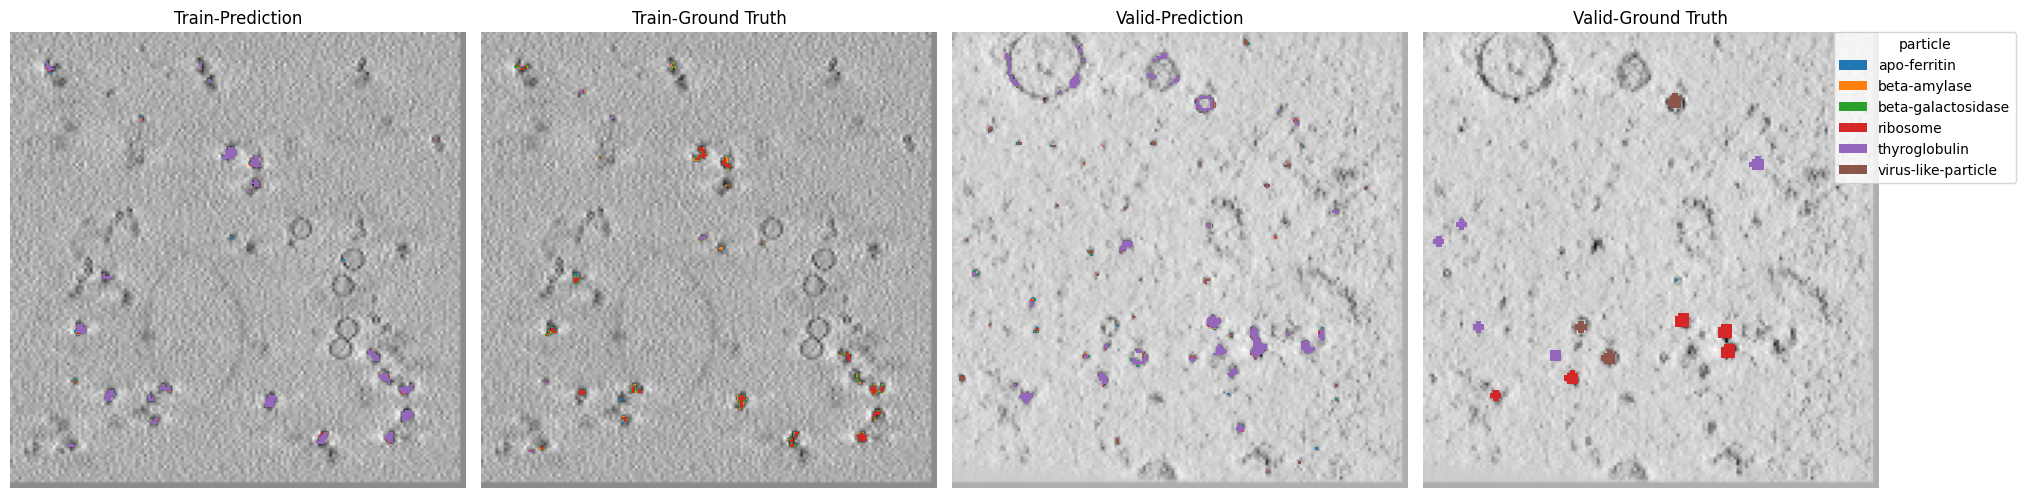

Train-Epoch: 11, Loss: 0.3949842454363766: : 219it [00:41,  5.30it/s]                        
Train-nshuffle-Epoch: 11, Loss: 0.445516094943815:  99%|█████████▉| 1580/1600 [00:44<00:00, 35.19it/s]  


EPOCH: 11, TRAIN_SCORE: 0.10969065916689552, TRAIN_SCORE_LIST: [0.14072096128170894, 0.07151965361922276, 0.05051105300689327, 0.14142516195022162, 0.0, 0.07021284120573913, 0.22202059280206102, 0.08733800745934214, 0.14019284445572192, 0.061210518214276324, 0.17817314867848788, 0.04489579896228364, 0.26727666273120815, 0.12544525457567787, 0.08892428385461508, 0.07108500882342941, 0.08065400814276501, 0.09860365198711062, 0.0, 0.07193405365631185, 0.0, 0.2667833477674166, 0.03366696997270245, 0.03997648442092887, 0.030942846741900256, 0.2069291309691977, 0.1981653134409771, 0.1321949714504228, 0.049187207350472655, 0.16412839290759607, 0.14765727709689824, 0.22832564581506753]
EPOCH: 11, TRAIN_EASY_SCORE: 0.03743926721261311, TRAIN_EASY_SCORE_LIST: [0.013590639237101796, 0.10727214768857729, 0.024103178391578637, 0.019980524944667465, 0.0017175186906445744, 0.09536888421808434, 0.029412305058589754, 0.05341773650031301, 0.011016876479012295, 0.04150246435460444, 0.030589033037186252, 

Valid-Epoch: 11, Loss: 0.5329669334662511:  92%|█████████▏| 92/100 [00:00<00:00, 105.23it/s]


EPOCH: 11, VALID_SCORE: 0.04106906593504472, VALID_SCORE_LIST: [0.013261399204810512, 0.06887673266527893]
EPOCH: 11, VALID_EASY_SCORE: 0.07895174662857482, VALID_EASY_SCORE_LIST: [0.07740943569927317, 0.08049405755787649]


Train-Epoch: 12, Loss: 0.3994428596063836: : 219it [00:40,  5.39it/s]                        
Train-nshuffle-Epoch: 12, Loss: 0.4290287214539845:  99%|█████████▉| 1580/1600 [00:45<00:00, 34.79it/s] 


EPOCH: 12, TRAIN_SCORE: 0.17787122343740247, TRAIN_SCORE_LIST: [0.1363297277135397, 0.1094342944241404, 0.17192255985902652, 0.10930947721554375, 0.0, 0.09245484770046102, 0.23897754050206618, 0.19304205839705044, 0.12781954887218044, 0.169952746107661, 0.25485486252141404, 0.1438030146090456, 0.3557685893073957, 0.17532288020326298, 0.21585527507012675, 0.1163262256942221, 0.07495922209896842, 0.20295889360411026, 0.0, 0.19833955857700195, 0.0, 0.3190764505023412, 0.1617536213144275, 0.15017389955291033, 0.16620107302647563, 0.3131680428889325, 0.2970391129523578, 0.2274762552348748, 0.1616194456954614, 0.26406165540589793, 0.2523433581302812, 0.29153491281570104]
EPOCH: 12, TRAIN_EASY_SCORE: 0.038823203839802214, TRAIN_EASY_SCORE_LIST: [0.04565556520664999, 0.1211194061744735, 0.02631023668937093, 0.026197984404224463, 0.0017175186906445744, 0.030089908410052907, 0.02665625299182842, 0.042705328733514056, 0.030886859163036108, 0.0412213926081692, 0.03504300144919983, 0.02976788533241

Valid-Epoch: 12, Loss: 0.4134180389709123:  92%|█████████▏| 92/100 [00:00<00:00, 116.93it/s] 


EPOCH: 12, VALID_SCORE: 0.08079748099526535, VALID_SCORE_LIST: [0.0896341460966604, 0.07196081589387028]
EPOCH: 12, VALID_EASY_SCORE: 0.050380805701852424, VALID_EASY_SCORE_LIST: [0.04664883186874027, 0.05411277953496457]


Train-Epoch: 13, Loss: 0.3972429858699237: : 219it [00:41,  5.26it/s]                        
Train-nshuffle-Epoch: 13, Loss: 0.4495007452025974:  99%|█████████▉| 1580/1600 [00:44<00:00, 35.16it/s] 


EPOCH: 13, TRAIN_SCORE: 0.1010864063996838, TRAIN_SCORE_LIST: [0.0, 0.08442310875682832, 0.09960260851844305, 0.0, 0.0, 0.10662020905923345, 0.14086841233012926, 0.1205167669418404, 0.0, 0.11293474013286442, 0.1406065380070894, 0.09274802753063624, 0.13877551020408166, 0.0774717654051912, 0.13114843792744982, 0.10153349475383373, 0.08037825059101654, 0.12833551769331586, 0.0, 0.12751677852348994, 0.0, 0.14137019495539158, 0.1707910169287326, 0.10461300027349804, 0.11115760841136162, 0.13885485583598792, 0.143212382643999, 0.13594121460989841, 0.18165904160491442, 0.13824493263745602, 0.14190015418150884, 0.14354043633169017]
EPOCH: 13, TRAIN_EASY_SCORE: 0.029239010616390775, TRAIN_EASY_SCORE_LIST: [0.0015331890331890335, 0.12850936865974458, 0.00952571152969516, 0.0016900288299035687, 0.0017175186906445744, 0.03183233892453751, 0.01338021752147624, 0.017173601954155272, 0.001614741641337386, 0.009936882564971924, 0.016137186470530675, 0.028028108528633324, 0.014509079682490088, 0.05755

Valid-Epoch: 13, Loss: 0.4487823895988581:  92%|█████████▏| 92/100 [00:00<00:00, 94.50it/s]  


EPOCH: 13, VALID_SCORE: 0.07055769962312822, VALID_SCORE_LIST: [0.08429226307418843, 0.05682313617206802]
EPOCH: 13, VALID_EASY_SCORE: 0.04573655001377308, VALID_EASY_SCORE_LIST: [0.04066419795367952, 0.05080890207386663]


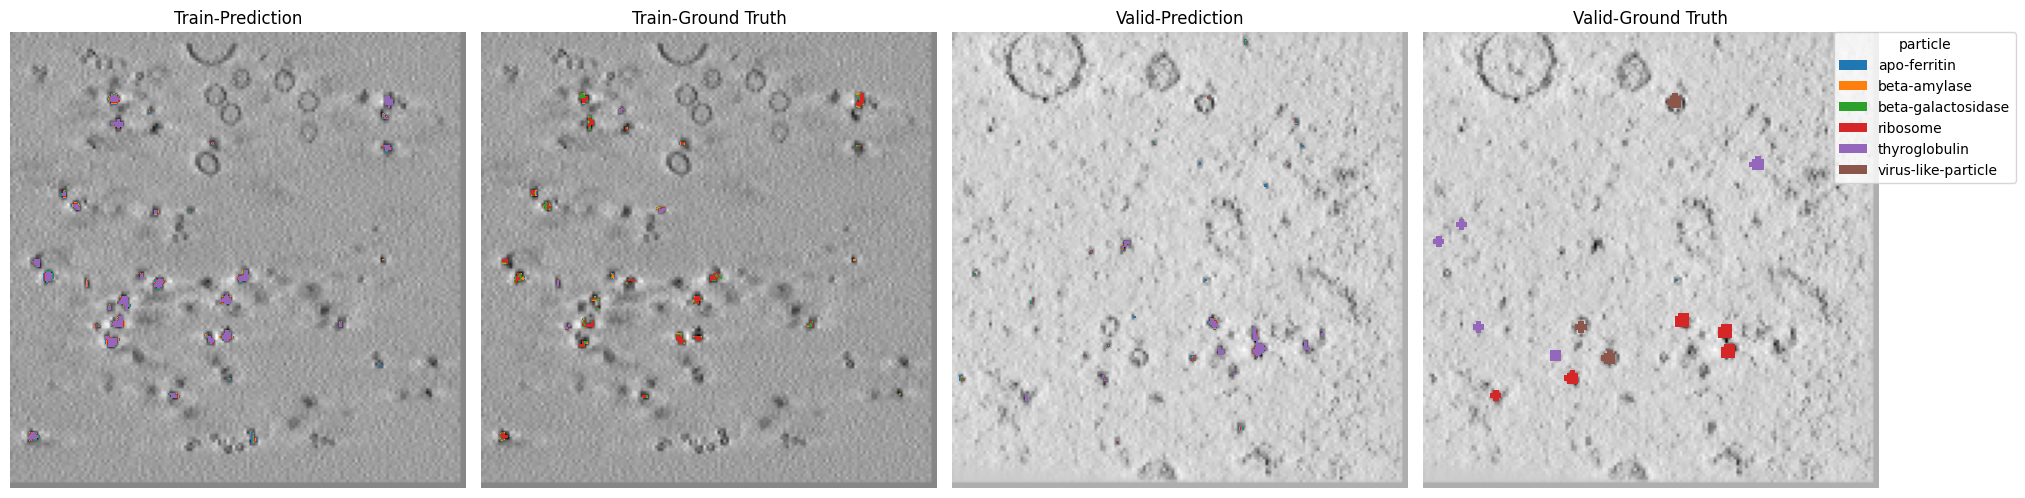

Train-Epoch: 14, Loss: 0.38752185648570864: : 219it [00:41,  5.33it/s]                       
Train-nshuffle-Epoch: 14, Loss: 0.4209506997991872:  99%|█████████▉| 1580/1600 [00:45<00:00, 34.85it/s] 


EPOCH: 14, TRAIN_SCORE: 0.09356905074175971, TRAIN_SCORE_LIST: [0.14150731158605173, 0.03778496822783845, 0.11133581928291622, 0.142553320775354, 0.0, 0.04612851002065539, 0.09767851350725175, 0.0502433183011032, 0.14047996377631877, 0.08327389890761383, 0.10437301897552796, 0.11655043405615488, 0.10052034058656575, 0.12060309071934738, 0.20742721344586393, 0.09996723118399689, 0.04819620397479046, 0.11777140511829838, 0.0, 0.09439796530979813, 0.027597402597402593, 0.09072666723593203, 0.12369233806442305, 0.15468884801328278, 0.11368227288087732, 0.10623367310351893, 0.08057503231618944, 0.13104263375324585, 0.0907400195074622, 0.05642888457443477, 0.06865416817152051, 0.08935515576257425]
EPOCH: 14, TRAIN_EASY_SCORE: 0.04424793561025122, TRAIN_EASY_SCORE_LIST: [0.014464879281173211, 0.10012965652764087, 0.0454128435531072, 0.020964405247137132, 0.0017175186906445744, 0.14423867685621888, 0.015876182015452624, 0.03327275491797577, 0.009270483447692154, 0.03195894447656371, 0.04601597

Valid-Epoch: 14, Loss: 0.6042640335787006:  92%|█████████▏| 92/100 [00:00<00:00, 120.62it/s]


EPOCH: 14, VALID_SCORE: 0.02473981884987568, VALID_SCORE_LIST: [0.023533810412861005, 0.025945827286890356]
EPOCH: 14, VALID_EASY_SCORE: 0.14103847449031415, VALID_EASY_SCORE_LIST: [0.12660454677093713, 0.15547240220969116]


Train-Epoch: 15, Loss: 0.39113701168941034: : 219it [00:40,  5.37it/s]                       
Train-nshuffle-Epoch: 15, Loss: 0.5738506029377521:  58%|█████▊    | 929/1600 [00:25<00:16, 40.29it/s] 

KeyboardInterrupt: 

Train-nshuffle-Epoch: 15, Loss: 0.5738506029377521:  58%|█████▊    | 930/1600 [00:39<00:16, 40.29it/s]

In [8]:
best_model = None
best_score = 0

for epoch in range(CFG.epochs):
    train_loss = []
    train_nshuffle_loss = []
    valid_loss = []

    # train_original_tomogram = defaultdict(list)
    ##train_pred_tomogram = defaultdict(list)
    # train_gt_tomogram = defaultdict(list)

    train_nshuffle_original_tomogram = defaultdict(list)
    train_nshuffle_pred_tomogram = defaultdict(list)
    train_nshuffle_gt_tomogram = defaultdict(list)

    valid_original_tomogram = defaultdict(list)
    valid_pred_tomogram = defaultdict(list)
    valid_gt_tomogram = defaultdict(list)

    model.train()
    tq = tqdm(range(len(train_loader) * normalized_tomogram.shape[0] // batch_size))
    for data in train_loader:
        exp_name = data["exp_name"][0]
        tomogram = data["normalized_tomogram"]
        segmentation_map = data["segmentation_map"]

        tomogram = tomogram.reshape(1, -1, tomogram.shape[-2], tomogram.shape[-1])
        segmentation_map = segmentation_map.reshape(
            1, -1, segmentation_map.shape[-2], segmentation_map.shape[-1]
        )

        for i in range(0, tomogram.shape[1], batch_size):
            optimizer.zero_grad()
            input_ = tomogram[:, i : i + batch_size].to("cuda").transpose(0, 1)
            gt = segmentation_map[:, i : i + batch_size].to("cuda").long().squeeze()
            # print(input_.shape, gt.shape)

            input_ = padf(input_)
            gt = padf(gt)
            input_, gt = aug(input_, gt)
            output = model(input_)
            loss = seg_loss(output, gt)
            loss.backward()
            optimizer.step()
            scheduler.step()

            train_loss.append(loss.item())
            tq.set_description(f"Train-Epoch: {epoch}, Loss: {np.mean(train_loss)}")
            tq.update(1)

            # print(output.shape, gt.shape) # torch.Size([1, 7, 160, 160]) torch.Size([1, 160, 160])
            # train_pred_tomogram[exp_name].append(output.cpu().detach().numpy())
            # train_gt_tomogram[exp_name].append(gt.cpu().detach().numpy())
    tq.close()
    train_exp_name = exp_name

    ######################################## train-nshuffle #########################################
    model.eval()
    tq = tqdm(range(len(train_nshuffle_loader) * normalized_tomogram.shape[0]))
    for data in train_nshuffle_loader:
        exp_name = data["exp_name"][0]
        tomogram = data["normalized_tomogram"].to("cuda")
        segmentation_map = data["segmentation_map"].to("cuda").long()

        train_nshuffle_original_tomogram[exp_name] = (
            padf(tomogram).squeeze().cpu().detach().numpy()
        )

        for i in range(tomogram.shape[1]):
            input_ = tomogram[:, i].unsqueeze(0)
            gt = segmentation_map[:, i]

            input_ = padf(input_)
            gt = padf(gt)
            output = model(input_)
            loss = seg_loss(output, gt)

            train_nshuffle_loss.append(loss.item())
            tq.set_description(
                f"Train-nshuffle-Epoch: {epoch}, Loss: {np.mean(train_nshuffle_loss)}"
            )
            tq.update(1)

            # print(output.shape, gt.shape) # torch.Size([1, 7, 160, 160]) torch.Size([1, 160, 160])
            train_nshuffle_pred_tomogram[exp_name].append(output.cpu().detach().numpy())
            train_nshuffle_gt_tomogram[exp_name].append(gt.cpu().detach().numpy())
    tq.close()

    train_score_, train_score_list = visualize_epoch_results(
        train_nshuffle_pred_tomogram,
        base_dir="../../inputs/train/overlay/ExperimentRuns/",
        sikii_dict=CFG.initial_sikii,
    )
    print(
        f"EPOCH: {epoch}, TRAIN_SCORE: {train_score_}, TRAIN_SCORE_LIST: {train_score_list}"
    )

    train_easy_score_, train_easy_score_list = visualize_epoch_results(
        train_nshuffle_pred_tomogram,
        base_dir="../../inputs/train/overlay/ExperimentRuns/",
        sikii_dict=CFG.initial_sikii,
        gt_tomogram_dict=train_nshuffle_gt_tomogram,
    )
    print(
        f"EPOCH: {epoch}, TRAIN_EASY_SCORE: {train_easy_score_}, TRAIN_EASY_SCORE_LIST: {train_easy_score_list}"
    )

    ############################################# valid #############################################

    model.eval()
    tq = tqdm(range(len(valid_loader) * normalized_tomogram.shape[0]))
    for data in valid_loader:
        exp_name = data["exp_name"][0]
        tomogram = data["normalized_tomogram"].to("cuda")
        segmentation_map = data["segmentation_map"].to("cuda").long()

        valid_original_tomogram[exp_name] = (
            padf(tomogram).squeeze().cpu().detach().numpy()
        )

        for i in range(tomogram.shape[1]):
            input_ = tomogram[:, i].unsqueeze(0)
            gt = segmentation_map[:, i]

            input_ = padf(input_)
            gt = padf(gt)
            output = model(input_)
            loss = seg_loss(output, gt)

            valid_loss.append(loss.item())
            tq.set_description(f"Valid-Epoch: {epoch}, Loss: {np.mean(valid_loss)}")
            tq.update(1)

            # print(output.shape, gt.shape) # torch.Size([1, 7, 160, 160]) torch.Size([1, 160, 160])
            valid_pred_tomogram[exp_name].append(output.cpu().detach().numpy())
            valid_gt_tomogram[exp_name].append(gt.cpu().detach().numpy())
    tq.close()
    valid_exp_name = exp_name

    valid_score_, valid_score_list = visualize_epoch_results(
        valid_pred_tomogram,
        base_dir="../../inputs/train/overlay/ExperimentRuns/",
        sikii_dict=CFG.initial_sikii,
    )
    print(
        f"EPOCH: {epoch}, VALID_SCORE: {valid_score_}, VALID_SCORE_LIST: {valid_score_list}"
    )
    valid_easy_score_, valid_easy_score_list = visualize_epoch_results(
        valid_pred_tomogram,
        base_dir="../../inputs/train/overlay/ExperimentRuns/",
        sikii_dict=CFG.initial_sikii,
        gt_tomogram_dict=valid_gt_tomogram,
    )
    print(
        f"EPOCH: {epoch}, VALID_EASY_SCORE: {valid_easy_score_}, VALID_EASY_SCORE_LIST: {valid_easy_score_list}"
    )

    if valid_score_ > best_score:
        best_score = valid_score_
        best_model = model
        torch.save(model.state_dict(), f"best_model.pth")

    # 描画
    index = 30
    plt.figure(figsize=(20, 5))

    # Train-Pred-Plot
    ax = plt.subplot(1, 4, 1)
    pred = train_nshuffle_pred_tomogram[train_exp_name][index][0].argmax(0)
    plot_with_colormap(
        pred,
        "Train-Prediction",
        train_nshuffle_original_tomogram[train_exp_name][index],
    )

    # Train-GT-Plot
    ax = plt.subplot(1, 4, 2)
    gt = train_nshuffle_gt_tomogram[train_exp_name][index][0]
    plot_with_colormap(
        gt,
        "Train-Ground Truth",
        train_nshuffle_original_tomogram[train_exp_name][index],
    )

    # Valid-Pred-Plot
    ax = plt.subplot(1, 4, 3)
    pred = valid_pred_tomogram[valid_exp_name][index][0].argmax(0)
    plot_with_colormap(
        pred, "Valid-Prediction", valid_original_tomogram[valid_exp_name][index]
    )

    # Valid-GT-Plot
    ax = plt.subplot(1, 4, 4)
    gt = valid_gt_tomogram[valid_exp_name][index][0]
    plot_with_colormap(
        gt, "Valid-Ground Truth", valid_original_tomogram[valid_exp_name][index]
    )

    # 凡例を追加
    legend_elements = [
        Patch(facecolor=colors[i - 1], label=CFG.particles_name[i - 1])
        for i in range(1, num_classes + 1)
    ]
    plt.legend(
        handles=legend_elements,
        loc="upper right",
        title="particle",
        bbox_to_anchor=(1.3, 1),  # 凡例を右上に配置
        borderaxespad=0,
    )

    plt.tight_layout()
    plt.show()

    # torch.save(model.state_dict(), "pretrained_model.pth")

Train-nshuffle-Epoch: 15, Loss: 0.5738506029377521:  58%|█████▊    | 930/1600 [01:03<00:45, 14.59it/s]
Train-nshuffle-Epoch: 0, Loss: 0.5163904448471598:  99%|█████████▉| 1580/1600 [00:50<00:00, 31.48it/s]


EPOCH: 0, TRAIN_SCORE: 0.15107866678105925, TRAIN_SCORE_LIST: [0.0, 0.07303974221267454, 0.38127500691017674, 0.0, 0.0, 0.09618104667609619, 0.08697363242817789, 0.141085977430292, 0.0, 0.32601566510142393, 0.14436460479372898, 0.3264181045871187, 0.04415584415584416, 0.0599647266313933, 0.30353360035603033, 0.0927859515899383, 0.10427764326069411, 0.24868554587347808, 0.0, 0.20614940516458774, 0.0, 0.12112575703598148, 0.34601461427315694, 0.2800939397410929, 0.3338930156376403, 0.026835043409629045, 0.13423376623376623, 0.20473841756242847, 0.3356618819776715, 0.14313594290175086, 0.1433561199540941, 0.1305223410950283]
EPOCH: 0, TRAIN_EASY_SCORE: 0.03835543106827008, TRAIN_EASY_SCORE_LIST: [0.0015331890331890335, 0.13127304739081527, 0.02760887160568698, 0.0016900288299035687, 0.0017175186906445744, 0.10957041691780953, 0.012316330034879136, 0.01758847338372309, 0.001614741641337386, 0.032838742709554745, 0.0170513160609544, 0.034006851372369494, 0.006742967457253173, 0.123616800364

Valid-Epoch: 0, Loss: 0.4897097552463453:  92%|█████████▏| 92/100 [00:00<00:00, 103.95it/s] 


EPOCH: 0, VALID_SCORE: 0.11551824990542267, VALID_SCORE_LIST: [0.10291963675422323, 0.1281168630566221]
EPOCH: 0, VALID_EASY_SCORE: 0.09930558321491052, VALID_EASY_SCORE_LIST: [0.08382569884136624, 0.1147854675884548]


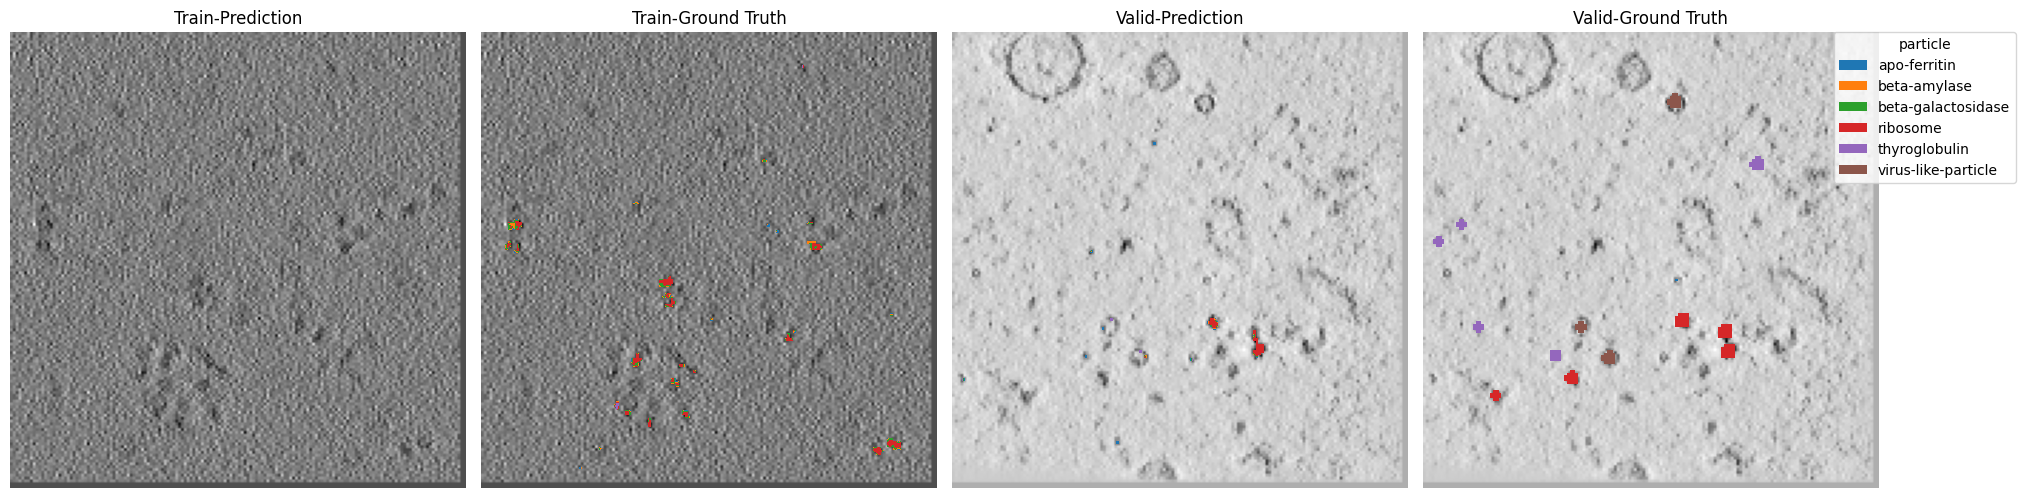

In [9]:
for epoch in range(CFG.epochs):
    train_loss = []
    train_nshuffle_loss = []
    valid_loss = []

    # train_original_tomogram = defaultdict(list)
    ##train_pred_tomogram = defaultdict(list)
    # train_gt_tomogram = defaultdict(list)

    train_nshuffle_original_tomogram = defaultdict(list)
    train_nshuffle_pred_tomogram = defaultdict(list)
    train_nshuffle_gt_tomogram = defaultdict(list)

    valid_original_tomogram = defaultdict(list)
    valid_pred_tomogram = defaultdict(list)
    valid_gt_tomogram = defaultdict(list)

    # model.train()
    # tq = tqdm(range(len(train_loader) * normalized_tomogram.shape[0] // batch_size))
    # for data in train_loader:
    #     exp_name = data["exp_name"][0]
    #     tomogram = data["normalized_tomogram"]
    #     segmentation_map = data["segmentation_map"]

    #     tomogram = tomogram.reshape(1, -1, tomogram.shape[-2], tomogram.shape[-1])
    #     segmentation_map = segmentation_map.reshape(
    #         1, -1, segmentation_map.shape[-2], segmentation_map.shape[-1]
    #     )

    #     for i in range(0, tomogram.shape[1], batch_size):
    #         optimizer.zero_grad()
    #         input_ = tomogram[:, i : i + batch_size].to("cuda").transpose(0, 1)
    #         gt = segmentation_map[:, i : i + batch_size].to("cuda").long().squeeze()
    #         # print(input_.shape, gt.shape)

    #         input_ = padf(input_)
    #         gt = padf(gt)
    #         input_, gt = aug(input_, gt)
    #         output = model(input_)
    #         loss = seg_loss(output, gt)
    #         loss.backward()
    #         optimizer.step()
    #         scheduler.step()

    #         train_loss.append(loss.item())
    #         tq.set_description(f"Train-Epoch: {epoch}, Loss: {np.mean(train_loss)}")
    #         tq.update(1)

    #         # print(output.shape, gt.shape) # torch.Size([1, 7, 160, 160]) torch.Size([1, 160, 160])
    #         # train_pred_tomogram[exp_name].append(output.cpu().detach().numpy())
    #         # train_gt_tomogram[exp_name].append(gt.cpu().detach().numpy())
    # tq.close()
    train_exp_name = exp_name

    ######################################## train-nshuffle #########################################
    model.eval()
    tq = tqdm(range(len(train_nshuffle_loader) * normalized_tomogram.shape[0]))
    for data in train_nshuffle_loader:
        exp_name = data["exp_name"][0]
        tomogram = data["normalized_tomogram"].to("cuda")
        segmentation_map = data["segmentation_map"].to("cuda").long()

        train_nshuffle_original_tomogram[exp_name] = (
            padf(tomogram).squeeze().cpu().detach().numpy()
        )

        for i in range(tomogram.shape[1]):
            input_ = tomogram[:, i].unsqueeze(0)
            gt = segmentation_map[:, i]

            input_ = padf(input_)
            gt = padf(gt)
            output = model(input_)
            loss = seg_loss(output, gt)

            train_nshuffle_loss.append(loss.item())
            tq.set_description(
                f"Train-nshuffle-Epoch: {epoch}, Loss: {np.mean(train_nshuffle_loss)}"
            )
            tq.update(1)

            # print(output.shape, gt.shape) # torch.Size([1, 7, 160, 160]) torch.Size([1, 160, 160])
            train_nshuffle_pred_tomogram[exp_name].append(output.cpu().detach().numpy())
            train_nshuffle_gt_tomogram[exp_name].append(gt.cpu().detach().numpy())
    tq.close()

    train_score_, train_score_list = visualize_epoch_results(
        train_nshuffle_pred_tomogram,
        base_dir="../../inputs/train/overlay/ExperimentRuns/",
        sikii_dict=CFG.initial_sikii,
    )
    print(
        f"EPOCH: {epoch}, TRAIN_SCORE: {train_score_}, TRAIN_SCORE_LIST: {train_score_list}"
    )

    train_easy_score_, train_easy_score_list = visualize_epoch_results(
        train_nshuffle_pred_tomogram,
        base_dir="../../inputs/train/overlay/ExperimentRuns/",
        sikii_dict=CFG.initial_sikii,
        gt_tomogram_dict=train_nshuffle_gt_tomogram,
    )
    print(
        f"EPOCH: {epoch}, TRAIN_EASY_SCORE: {train_easy_score_}, TRAIN_EASY_SCORE_LIST: {train_easy_score_list}"
    )

    ############################################# valid #############################################

    model.eval()
    tq = tqdm(range(len(valid_loader) * normalized_tomogram.shape[0]))
    for data in valid_loader:
        exp_name = data["exp_name"][0]
        tomogram = data["normalized_tomogram"].to("cuda")
        segmentation_map = data["segmentation_map"].to("cuda").long()

        valid_original_tomogram[exp_name] = (
            padf(tomogram).squeeze().cpu().detach().numpy()
        )

        for i in range(tomogram.shape[1]):
            input_ = tomogram[:, i].unsqueeze(0)
            gt = segmentation_map[:, i]

            input_ = padf(input_)
            gt = padf(gt)
            output = model(input_)
            loss = seg_loss(output, gt)

            valid_loss.append(loss.item())
            tq.set_description(f"Valid-Epoch: {epoch}, Loss: {np.mean(valid_loss)}")
            tq.update(1)

            # print(output.shape, gt.shape) # torch.Size([1, 7, 160, 160]) torch.Size([1, 160, 160])
            valid_pred_tomogram[exp_name].append(output.cpu().detach().numpy())
            valid_gt_tomogram[exp_name].append(gt.cpu().detach().numpy())
    tq.close()
    valid_exp_name = exp_name

    valid_score_, valid_score_list = visualize_epoch_results(
        valid_pred_tomogram,
        base_dir="../../inputs/train/overlay/ExperimentRuns/",
        sikii_dict=CFG.initial_sikii,
    )
    print(
        f"EPOCH: {epoch}, VALID_SCORE: {valid_score_}, VALID_SCORE_LIST: {valid_score_list}"
    )
    valid_easy_score_, valid_easy_score_list = visualize_epoch_results(
        valid_pred_tomogram,
        base_dir="../../inputs/train/overlay/ExperimentRuns/",
        sikii_dict=CFG.initial_sikii,
        gt_tomogram_dict=valid_gt_tomogram,
    )
    print(
        f"EPOCH: {epoch}, VALID_EASY_SCORE: {valid_easy_score_}, VALID_EASY_SCORE_LIST: {valid_easy_score_list}"
    )

    if valid_score_ > best_score:
        best_score = valid_score_
        best_model = model
        torch.save(model.state_dict(), f"best_model.pth")

    # 描画
    index = 30
    plt.figure(figsize=(20, 5))

    # Train-Pred-Plot
    ax = plt.subplot(1, 4, 1)
    pred = train_nshuffle_pred_tomogram[train_exp_name][index][0].argmax(0)
    plot_with_colormap(
        pred,
        "Train-Prediction",
        train_nshuffle_original_tomogram[train_exp_name][index],
    )

    # Train-GT-Plot
    ax = plt.subplot(1, 4, 2)
    gt = train_nshuffle_gt_tomogram[train_exp_name][index][0]
    plot_with_colormap(
        gt,
        "Train-Ground Truth",
        train_nshuffle_original_tomogram[train_exp_name][index],
    )

    # Valid-Pred-Plot
    ax = plt.subplot(1, 4, 3)
    pred = valid_pred_tomogram[valid_exp_name][index][0].argmax(0)
    plot_with_colormap(
        pred, "Valid-Prediction", valid_original_tomogram[valid_exp_name][index]
    )

    # Valid-GT-Plot
    ax = plt.subplot(1, 4, 4)
    gt = valid_gt_tomogram[valid_exp_name][index][0]
    plot_with_colormap(
        gt, "Valid-Ground Truth", valid_original_tomogram[valid_exp_name][index]
    )

    # 凡例を追加
    legend_elements = [
        Patch(facecolor=colors[i - 1], label=CFG.particles_name[i - 1])
        for i in range(1, num_classes + 1)
    ]
    plt.legend(
        handles=legend_elements,
        loc="upper right",
        title="particle",
        bbox_to_anchor=(1.3, 1),  # 凡例を右上に配置
        borderaxespad=0,
    )

    plt.tight_layout()
    plt.show()

    # torch.save(model.state_dict(), "pretrained_model.pth")
    break

In [13]:
train_nshuffle_gt_tomogram.keys()

dict_keys(['TS_4', 'TS_5_4', 'TS_21', 'TS_3', 'TS_1', 'TS_73_6', 'TS_7', 'TS_19', 'TS_5', 'TS_23', 'TS_12', 'TS_26', 'TS_8', 'TS_99_9', 'TS_20', 'TS_6_4', 'TS_69_2', 'TS_17', 'TS_0', 'TS_16', 'TS_2', 'TS_10', 'TS_25', 'TS_24', 'TS_22', 'TS_6', 'TS_9', 'TS_15', 'TS_18', 'TS_13', 'TS_14', 'TS_11'])

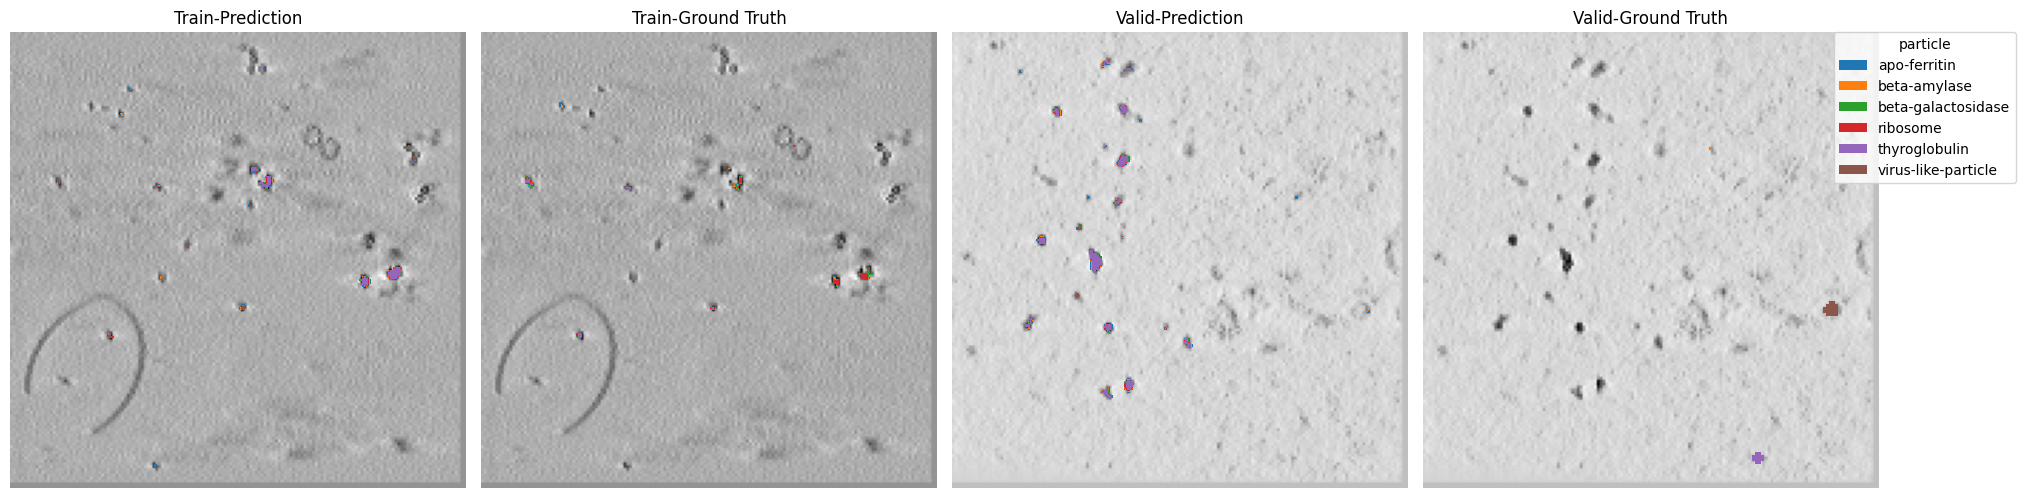

In [14]:
# 描画
index = 5
train_exp_name = "TS_19"

plt.figure(figsize=(20, 5))

# Train-Pred-Plot
ax = plt.subplot(1, 4, 1)
pred = train_nshuffle_pred_tomogram[train_exp_name][index][0].argmax(0)
plot_with_colormap(
    pred,
    "Train-Prediction",
    train_nshuffle_original_tomogram[train_exp_name][index],
)

# Train-GT-Plot
ax = plt.subplot(1, 4, 2)
gt = train_nshuffle_gt_tomogram[train_exp_name][index][0]
plot_with_colormap(
    gt,
    "Train-Ground Truth",
    train_nshuffle_original_tomogram[train_exp_name][index],
)

# Valid-Pred-Plot
ax = plt.subplot(1, 4, 3)
pred = valid_pred_tomogram[valid_exp_name][index][0].argmax(0)
plot_with_colormap(
    pred, "Valid-Prediction", valid_original_tomogram[valid_exp_name][index]
)

# Valid-GT-Plot
ax = plt.subplot(1, 4, 4)
gt = valid_gt_tomogram[valid_exp_name][index][0]
plot_with_colormap(
    gt, "Valid-Ground Truth", valid_original_tomogram[valid_exp_name][index]
)

# 凡例を追加
legend_elements = [
    Patch(facecolor=colors[i - 1], label=CFG.particles_name[i - 1])
    for i in range(1, num_classes + 1)
]
plt.legend(
    handles=legend_elements,
    loc="upper right",
    title="particle",
    bbox_to_anchor=(1.3, 1),  # 凡例を右上に配置
    borderaxespad=0,
)

plt.tight_layout()
plt.show()

# torch.save(model.state_dict(), "pretrained_model.pth")

In [15]:
pred = train_nshuffle_pred_tomogram[train_exp_name][index][0].argmax(0)
gt = train_nshuffle_gt_tomogram[train_exp_name][index][0]

In [16]:
pred.shape, gt.shape

((160, 160), (160, 160))

In [27]:
# value_countsみたいな感じで、クラスごとの数を出す

np.unique(pred[pred > 0], return_counts=True)

(array([1, 2, 3, 4, 5]), array([65,  8,  1, 59, 42]))

In [28]:
np.unique(gt[gt > 0], return_counts=True)

(array([1, 2, 3, 4, 5, 6]), array([47, 34, 33, 38, 28,  3]))